## Best Director

### Überblick

#### Ziel

Das Ziel unseres Projekts besteht darin, Daten aus drei unterschiedlichen Quellen zu Filmen und deren Bewertungen zu sammeln und zu analysieren. Unser Schwerpunkt liegt darauf, herauszufinden, welcher Regisseur die beliebtesten Filme produziert hat und ob sich die Bewertungen dieser Filme auf verschiedenen Plattformen stark unterscheiden.

#### Daten

- Kaggle Film Datensatz: Der Kaggle-Datensatz bietet umfassende Informationen zu Filmen, die bis zum Jahr 2020 veröffentlicht wurden. Dazu gehören Details wie Titel, Regisseur, Bewertungen, Einnahmen und viele weitere relevante Daten. Wir nutzen diesen Datensatz, um Regisseure anhand der Bewertungen ihrer Filme zu identifizieren und eine erste Analyse durchzuführen.


- OMDB API Daten: Aufbauend auf den im Kaggle-Datensatz identifizierten Filmen, rufen wir zusätzliche Bewertungen von IMDb und Rotten Tomatoes über die OMDB API ab. Diese Daten ermöglichen es uns, die Bewertungen zwischen den beiden Plattformen zu vergleichen und ein umfassenderes Bild der Filmbewertungen zu erhalten.

- IMDB Web-Scraped Daten: Da der Kaggle-Datensatz nur Filme bis zum Jahr 2020 enthält, führen wir ein Web-Scraping durch, um die neuesten Projekte der Regisseure ab 2020 zu erfassen. Diese Daten ergänzen unsere Analyse.

### Architektur

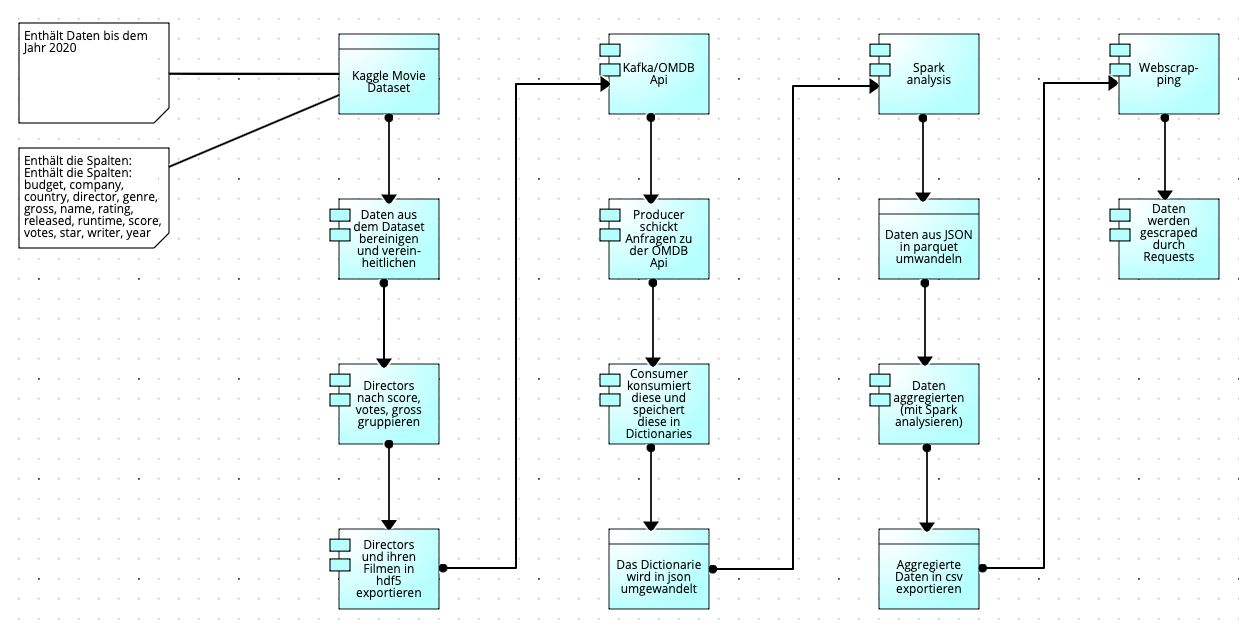

In [77]:
from IPython.display import Image, display
image_path = "C:\\Users\\jelen\\Downloads\\architektur.jpeg"
display(Image(filename=image_path))

### Daten von Kaggle

Im ersten Schritt werden die notwendigen Python-Bibliotheken importiert und der Datensatz aus der CSV-Datei geladen. 

In [11]:
import matplotlib.pyplot as plt
import json
import pandas as pd
df = pd.read_csv('movies-two.csv')
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


Der Datensatz enthält Name, Rating, Genre, Jahr, Release-Jahr sowie Ort, (User)Score, die Anzahl der Votes, Regisseur, Writer, den berühmtesten Schauspieler, das Land, das Budget, Einnahme, das Unternehmen sowie die Länge des Films. Viele Informationen sind für unsere Analyse nicht notwendig, somit entfernen wir unnötige Spalten. 

In [12]:
df = df.drop(columns=['budget', 'star', 'writer', 'company', 'rating', 'country', 'runtime', 'released'])

Jetzt sehen wir uns an, wie viele Daten enthalten sind.

In [13]:
df.count()

name        7668
genre       7668
year        7668
score       7665
votes       7665
director    7668
gross       7479
dtype: int64

7668 Daten sind im Datensatz enthalten. Jedoch wirkt es, als würden Werte fehlen. Das sehen wir uns an:

In [14]:
print("Null values in each column: ", df.isnull().sum())

Null values in each column:  name          0
genre         0
year          0
score         3
votes         3
director      0
gross       189
dtype: int64


Es fehlen Werte. Somit entfernen wir diese: 

In [15]:
df = df.dropna()

In [16]:
print("Null values in each column: ", df.isnull().sum())

Null values in each column:  name        0
genre       0
year        0
score       0
votes       0
director    0
gross       0
dtype: int64


Es sind keine fehlenden Daten mehr enthalten. Jetzt sehen wir uns an, ob alle Daten den passenden Datentyp enthalten: 

In [17]:
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
print("Column names and data types:", df.dtypes)

Number of rows: 7479
Number of columns: 7
Column names and data types: name         object
genre        object
year          int64
score       float64
votes       float64
director     object
gross       float64
dtype: object


Wir haben nun 7479 Filme und die Datentypen passen auch. Schauen wir mal nach, ob Duplikate vorhanden sind:

In [18]:
print("Number of duplicate rows:", df.duplicated().sum())

Number of duplicate rows: 0


Es sind keine Duplikate vorhanden. Wir sehen uns den gereinigten Datensatz nocheinmal an:

In [19]:
df.head()

,name,genre,year,score,votes,director,gross
0,The Shining,Drama,1980,8.4,927000.0,Stanley Kubrick,46998772.0
1,The Blue Lagoon,Adventure,1980,5.8,65000.0,Randal Kleiser,58853106.0
2,Star Wars: Episode V - The Empire Strikes Back,Action,1980,8.7,1200000.0,Irvin Kershner,538375067.0
3,Airplane!,Comedy,1980,7.7,221000.0,Jim Abrahams,83453539.0
4,Caddyshack,Comedy,1980,7.3,108000.0,Harold Ramis,39846344.0


Nun gruppieren wir nach der Spalte "director" und aggregieren, um den durchschnittlichen Bewertungsscore (score), die Gesamtanzahl der Stimmen (votes) und die Gesamtsumme des Bruttoeinnahmen (gross) für jeden Regisseur zu berechnen.

In [20]:
group_by_director = df.groupby('director').agg({
    'score': 'mean',
    'votes': 'sum',
    'gross': 'sum'
}).reset_index()

Im nächsten Schritt berechnen wir eine kombinierte Rangliste für jeden Regisseur basierend auf den Durchschnittswerten der Bewertung (score), der Gesamtanzahl der Stimmen (votes) und der Gesamtsumme des Bruttoeinkommens (gross). Anschließend sortieren wir die Regisseure nach dieser Rangliste und wählen die Top 10 Regisseure aus, um deren aggregierte Werte und Rang anzuzeigen.

In [21]:
group_by_director['rank'] = group_by_director[['score', 'votes', 'gross']].rank(method='max', ascending=False).mean(axis=1)
top_10_directors = group_by_director.sort_values('rank').head(10)
print(top_10_directors[['director', 'score', 'votes', 'gross', 'rank']])

               director     score       votes         gross       rank
473   Christopher Nolan  8.163636  12739000.0  5.153548e+09   8.333333
1116      James Cameron  7.871429   5090000.0  6.248089e+09  25.333333
2170  Quentin Tarantino  8.100000   8712000.0  1.870119e+09  27.666667
2116      Peter Jackson  7.745455   7577000.0  6.618046e+09  31.333333
2094        Pete Docter  8.133333   2441000.0  2.173655e+09  35.666667
602       David Fincher  7.760000   7375000.0  2.142318e+09  45.333333
1769    Martin Scorsese  7.673684   7641000.0  2.094151e+09  56.666667
161       Anthony Russo  7.580000   3337000.0  6.844249e+09  60.000000
1623        Lee Unkrich  8.300000   1193000.0  1.874789e+09  66.666667
1025     Hayao Miyazaki  8.142857   2055000.0  1.142123e+09  69.333333


Wie wir sehen können sind die beliebtesten Filme von folgenden Regisseuren: 

    - Christopher Nolan
    - James Cameron
    - Quentin Tarantino
    - Peter Jackson
    - David Fincher
    - Martin Scorsese
    - Anthony Russo
    - Lee Unkrich
    - Hayao Miyazaki

Im nächsten Schritt visualisieren wir die Ergebnisse der Top 10 Regisseure basierend auf verschiedenen Metriken. Wir erstellen drei horizontale Balkendiagramme, um die durchschnittlichen Bewertungen, die Gesamtanzahl der Stimmen und die Gesamteinnahmen der Regisseure darzustellen.

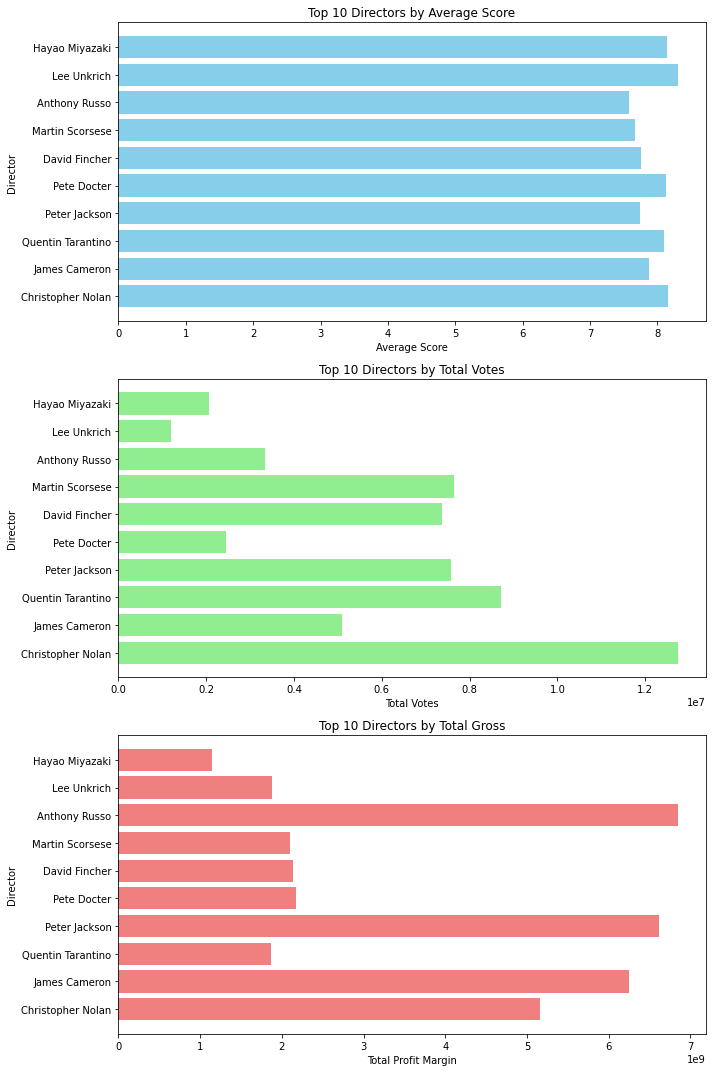

In [22]:
import json
import matplotlib.pyplot as plt
# Plotting
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
# Plot average scores
ax[0].barh(top_10_directors['director'], top_10_directors['score'], color='skyblue')
ax[0].set_title('Top 10 Directors by Average Score')
ax[0].set_xlabel('Average Score')
ax[0].set_ylabel('Director')


# Plot total votes
ax[1].barh(top_10_directors['director'], top_10_directors['votes'], color='lightgreen')
ax[1].set_title('Top 10 Directors by Total Votes')
ax[1].set_xlabel('Total Votes')
ax[1].set_ylabel('Director')

# Plot total profit margin
ax[2].barh(top_10_directors['director'], top_10_directors['gross'], color='lightcoral')
ax[2].set_title('Top 10 Directors by Total Gross')
ax[2].set_xlabel('Total Profit Margin')
ax[2].set_ylabel('Director')

plt.tight_layout()
plt.show()

#### Durchschnittliche Bewertung

Anthony Russo führt die Liste mit dem höchsten durchschnittlichen Bewertungsscore, wobei alle Regisseure einen durchschnittlichen Score von über 7 aufweisen, was auf eine allgemein hohe Qualität ihrer Filme hinweist.

#### Gesamtanzahl der Stimmen

Christopher Nolan erhält mit Abstand die meisten Stimmen, was auf eine hohe Popularität und Zuschauerzahl seiner Filme deutet. Einige Regisseure wie Hayao Miyazaki und Lee Unkrich haben im Vergleich viel weniger Stimmen, was eventuell daran liegen könnte, dass diese größtenteils bei animierten Filmen Regie geführt haben.

#### Gesamteinnahmen

Anthony Russo, Peter Jackson, James Cameron und Christopher Nolan dominieren bei den Gesamteinnahmen, was auf enorme Kassenerfolge zurückzuführen ist. Hayao Miyazaki hat im Vergleich geringere Gesamteinnahmen, was daran liegen könnte, dass seine animierten japanischen Filme nicht so großen internationalen Erfolg haben wie Hollywood-Blockbuster.

Die 10 besten Regisseure und die dazugehörigen Informationen exportieren wir als HDF5-Dateien:

In [23]:
# Export the top 10 directors data to HDF5
top_10_directors.to_hdf('top_10_directors_b.h5', key='directors', mode='w')

# Export their movies, ratings, votes, and gross profit margin
movies_info = df[df['director'].isin(top_10_directors['director'])]
movies_info.to_hdf('top_10_directors.h5', key='movies', mode='a')

## Kafka/OMDB Api


Sobald wir die notwendigen Daten aus dem Datensatz extrahiert haben, senden wir der OMDB-Api über Requests mittels Kafka Requests, um sicherzustellen, dass die Daten für die Filme im Datensatz bis 2020 keine Änderungen in ihrer IMDB-Bewertung erfahren haben. Wir extrahieren auch die Rotten Tomatoes-Bewertung und den Box Office. Auf diese Weise können wir weiter feststellen, ob die Filme der analysierten Regisseure tatsächlich die höchste Bewertung haben.

In [14]:
import json
import pandas as pd
import requests
import time
from confluent_kafka import Producer, Consumer, KafkaError

# Import the top directors and their movies from HDF5
top_10_directors = pd.read_hdf('top_10_directors_b.h5', key='directors')
movies_info = pd.read_hdf('top_10_directors.h5', key='movies')

# Kafka Producer configuration
producer_conf = {
    'bootstrap.servers': 'localhost:9092'
}
producer = Producer(producer_conf)
topic = 'omdb_movies'

# OMDB API configuration
omdb_api_key = '2a7e348a'
omdb_api_url = 'http://www.omdbapi.com/'

def fetch_movie_data(title):
    params = {
        't': title,
        'apikey': omdb_api_key
    }
    response = requests.get(omdb_api_url, params=params)
    return response.json()

def delivery_report(err, msg):
    if err:
        print(f"Message delivery failed: {err}")
    else:
        print(f"Message delivered to {msg.topic()} [{msg.partition()}]")

def produce_movie_data(title):
    print(f"Fetching data for movie: {title}")
    movie_data = fetch_movie_data(title)
    
    if movie_data.get('Response') == 'True':
        producer.produce(topic, key=title, value=json.dumps(movie_data), callback=delivery_report)
        producer.flush()
    else:
        print(f"Movie not found: {title}")

# Kafka Consumer configuration
consumer_conf = {
    'bootstrap.servers': 'localhost:9092',
    'group.id': 'omdb_group',
    'auto.offset.reset': 'earliest'
}
consumer = Consumer(consumer_conf)
consumer.subscribe([topic])

director_dict = {}

# Produce messages to Kafka
for title in movies_info['name'].tolist():
    produce_movie_data(title)
    time.sleep(1)  # To avoid hitting the API rate limit

# Consume messages from Kafka and update the dictionary
try:
    print("Starting Kafka consumer...")
    while True:
        print("Polling for new messages...")
        msg = consumer.poll(timeout=10.0)
        if msg is None:
            print("No message received. Polling again...")
            break
        if msg.error():
            if msg.error().code() == KafkaError._PARTITION_EOF:
                print("End of partition reached. Polling again...")
                continue
            else:
                print(f"Error: {msg.error()}")
                break

        # Deserialize JSON message
        movie_data = json.loads(msg.value().decode('utf-8'))
        print(f"Received movie data: {movie_data}")

        # Extract ratings and convert Rotten Tomatoes rating
        imdb_rating = None
        rt_rating = None
        for rating in movie_data.get('Ratings', []):
            if rating['Source'] == 'Internet Movie Database':
                imdb_rating = float(rating['Value'].split('/')[0])
            elif rating['Source'] == 'Rotten Tomatoes':
                rt_rating = float(rating['Value'].strip('%')) / 10
        
        # Extract other fields
        director = movie_data.get('Director', 'Unknown')
        box_office = movie_data.get('BoxOffice', '0')
        
        # Handle 'N/A' and other non-numeric box office values
        if box_office == 'N/A':
            box_office = 0
        else:
            box_office = float(box_office.replace('$', '').replace(',', '') or 0)

        # Update dictionary
        if director not in director_dict:
            director_dict[director] = {}
        director_dict[director][movie_data['Title']] = {
            'imdb_rating': imdb_rating,
            'rt_rating': rt_rating,
            'box_office': box_office
        }

except KeyboardInterrupt:
    print("Kafka consumer interrupted by user")
finally:
    consumer.close()
    print("Kafka consumer closed")

# Save the dictionary to a JSON file
with open('director_data_new111.json', 'w') as f:
    json.dump(director_dict, f, indent=4)

print("Data fetching and saving completed.")


Fetching data for movie: Raging Bull
Message delivered to omdb_movies [0]
Fetching data for movie: The King of Comedy
Message delivered to omdb_movies [0]
Fetching data for movie: The Terminator
Message delivered to omdb_movies [0]
Fetching data for movie: After Hours
Message delivered to omdb_movies [0]
Fetching data for movie: Aliens
Message delivered to omdb_movies [0]
Fetching data for movie: The Color of Money
Message delivered to omdb_movies [0]
Fetching data for movie: The Last Temptation of Christ
Message delivered to omdb_movies [0]
Fetching data for movie: The Abyss
Message delivered to omdb_movies [0]
Fetching data for movie: Goodfellas
Message delivered to omdb_movies [0]
Fetching data for movie: Terminator 2: Judgment Day
Message delivered to omdb_movies [0]
Fetching data for movie: Cape Fear
Message delivered to omdb_movies [0]
Fetching data for movie: Reservoir Dogs
Message delivered to omdb_movies [0]
Fetching data for movie: Alien 3
Message delivered to omdb_movies [0]

Wir verwenden Spark, um Daten aus einer JSON-Datei zu verarbeiten, die Informationen über Filme und ihre Regisseure enthält. Die Daten werden in ein DataFrame geladen, welches die Titel, Regisseure, IMDb-Bewertungen, Rotten Tomatoes-Bewertungen und Einnahmen der Filme enthält. Anschließend gruppieren wir die Daten im DataFrame, um die Gesamtboxoffice-Einnahmen sowie die durchschnittlichen IMDb- und Rotten Tomatoes-Bewertungen für jeden Regisseur zu berechnen. Die Ergebnisse werden schließlich in aggregierter Form angezeigt.

In [4]:
import json
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType
from pyspark.sql.functions import avg, sum as _sum

# Add logging
import logging
logging.basicConfig(level=logging.INFO)
# Set environment variables
os.environ['SPARK_HOME'] = '/opt/homebrew/opt/apache-spark'  
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3' 
# Load the dictionary from JSON file
with open('director_data_new111.json', 'r') as f:
    director_dict = json.load(f)

# Initialize Spark session
try:
    logging.info("Starting Spark session...")
    spark = SparkSession.builder \
        .appName("OMDB Data Analysis") \
        .getOrCreate()
    logging.info("Spark session started successfully.")
except Exception as e:
    logging.error(f"Error starting Spark session: {e}")
    raise e

# Define schema for the DataFrame
schema = StructType([
    StructField("Title", StringType(), True),
    StructField("Director", StringType(), True),
    StructField("IMDb_Rating", FloatType(), True),
    StructField("RT_Rating", FloatType(), True),
    StructField("BoxOffice", FloatType(), True)
])

# Convert dictionary to list of tuples
parquet_data = []
for director, movies in director_dict.items():
    for title, info in movies.items():
        imdb_rating = float(info['imdb_rating']) if 'imdb_rating' in info else None
        rt_rating = float(info['rt_rating']) / 10 if 'rt_rating' in info else None  # Convert RT rating to same scale
        box_office = float(info['box_office']) if 'box_office' in info else None
        parquet_data.append((title, director, imdb_rating, rt_rating, box_office))


try:
    logging.info("Creating Spark DataFrame...")
    parquet_df = spark.createDataFrame(parquet_data, schema=schema)
    logging.info("Spark DataFrame created successfully.")
except Exception as e:
    logging.error(f"Error creating Spark DataFrame: {e}")
    raise e


parquet_df.printSchema()
parquet_df.show(truncate=False)


aggregated_df = parquet_df.groupBy('Director').agg(
    _sum('BoxOffice').alias('Total_BoxOffice'),
    avg('IMDb_Rating').alias('Avg_IMDb_Rating'),
    avg('RT_Rating').alias('Avg_RT_Rating')
)

aggregated_df.show(truncate=False)

print("Data processing and aggregation completed.")


INFO:root:Starting Spark session...
ERROR:root:Error starting Spark session: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.


PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.

Aggregierten Daten exportieren, um das Webscrapping zu ermöglichen

In [ ]:
aggregated_df.write.mode('overwrite').csv('aggregated_directors.csv', header=True)

print("Aggregated data exported to CSV.")

### Webscraping

Wir übernehmen die Regisseure von dem Ergebnis des aggregierten Datendatzes. Da dieses nur Filme bis 2020 beinhaltet, scrapen wir die Filme und deren Bewertung ab dem Jahr 2020. 

In [51]:
import requests
from bs4 import BeautifulSoup

Zuerst nehmen wir uns die Regisseure, um zu sehen, welche Daten wir webscrapen müssen:

In [53]:
df_api = pd.read_csv('aggregated_directors.csv')
print(df_api)

                                     Director  Total_BoxOffice  \
0                             Martin Scorsese     9.591486e+08   
1                               James Cameron     1.990190e+09   
2                           Quentin Tarantino     7.667075e+08   
3                               David Fincher     8.651854e+08   
4                               Peter Jackson     2.141527e+09   
5                           Christopher Nolan     2.064891e+09   
6                 Andrew Stanton, Lee Unkrich     3.808433e+08   
7   Pete Docter, David Silverman, Lee Unkrich     2.906422e+08   
8                    Anthony Russo, Joe Russo     2.280668e+09   
9                  Lee Unkrich, Adrian Molina     2.104600e+08   
10                                Lee Unkrich     4.150049e+08   
11             Pete Docter, Ronnie Del Carmen     3.569217e+08   
12                             Andrew Stanton     2.968863e+08   
13              Andrew Stanton, Angus MacLane     4.862956e+08   
14        

Da bei der Abfrage der API mehrere Regisseure für einige Filme zurückgegeben wurden, möchten wir diese Datensätze entfernen:

In [55]:
df_api = df[~df['Director'].str.contains(",")]
print(df_api)

             Director  Total_BoxOffice  Avg_IMDb_Rating  Avg_RT_Rating
0     Martin Scorsese     9.591486e+08         7.668421       0.839474
1       James Cameron     1.990190e+09         7.957143       0.881429
2   Quentin Tarantino     7.667075e+08         8.133333       0.862222
3       David Fincher     8.651854e+08         7.750000       0.795000
4       Peter Jackson     2.141527e+09         7.763636       0.768182
5   Christopher Nolan     2.064891e+09         8.154545       0.849091
10        Lee Unkrich     4.150049e+08         8.300000       0.980000
12     Andrew Stanton     2.968863e+08         7.500000       0.735000


Um die Rotten Tomato und IMDb Ratings zu vereinhaltlichen, rechnen wir die Rotten Tomate Ratings * 10.

In [56]:
df_api['Avg_RT_Rating'] = df_api['Avg_RT_Rating'] * 10
print(df_api)

             Director  Total_BoxOffice  Avg_IMDb_Rating  Avg_RT_Rating
0     Martin Scorsese     9.591486e+08         7.668421       8.394737
1       James Cameron     1.990190e+09         7.957143       8.814286
2   Quentin Tarantino     7.667075e+08         8.133333       8.622222
3       David Fincher     8.651854e+08         7.750000       7.950000
4       Peter Jackson     2.141527e+09         7.763636       7.681818
5   Christopher Nolan     2.064891e+09         8.154545       8.490909
10        Lee Unkrich     4.150049e+08         8.300000       9.800000
12     Andrew Stanton     2.968863e+08         7.500000       7.350000


Wie man erkennen kann hat sich die Liste einwenig verändert. Drei Regisseure sind rausgefallen und dafür ist ein neuer dazu gekommen.

Eine Liste von URLS, die auf die IMDb-Seiten der Regisseure verweist, wird defininiert. Außerdem werden leere Listen erstellt, um die Filmtitel, die Bewertungen und die Regisseurnamen zu speichern.

In [36]:
urls = [
    'https://www.imdb.com/name/nm0881279/',
    'https://www.imdb.com/name/nm0000217/',
    'https://www.imdb.com/name/nm0000399/',
    'https://www.imdb.com/name/nm0001392/',
    'https://www.imdb.com/name/nm0000233/',
    'https://www.imdb.com/name/nm0000116/',
    'https://www.imdb.com/name/nm0634240/',
    'https://www.imdb.com/name/nm0004056/'
]

movies = []
ratings = []
directors = []
years = []

Die HTTP-Header werden definiert, um sicherzustellen, dass die Anfragen von einem normalen Webbrowser zu kommen scheinen.

In [37]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

Diese Funktion übernimmt die Aufgabe, den Titel, die Bewertung sowie das Veröffentlichungsjahr eines Films von einer IMDb-FIlmseite zu extrahieren:

In [38]:
def scrape_movie_details(movie_url):
    try:
        movie_response = requests.get(movie_url, headers=headers)
        movie_response.raise_for_status()
        movie_soup = BeautifulSoup(movie_response.content, 'html.parser')
        
        try:
            movie_title_tag = movie_soup.find('span', {'data-testid': 'hero__primary-text'})
            movie_title = movie_title_tag.text.strip() if movie_title_tag else 'N/A'
        except AttributeError:
            movie_title = 'N/A'
        
        try:
            rating_tag = movie_soup.find('span', {'class': 'sc-eb51e184-1 cxhhrI'})
            rating = rating_tag.text.strip() if rating_tag else 'N/A'
        except AttributeError:
            rating = 'N/A'
        
        return movie_title, rating
    except requests.RequestException as e:
        print(f"Error fetching movie URL: {movie_url} - {e}")
        return 'N/A', 'N/A'

Diese Funktion extrahier die Filmografie eines Regisseurs von der IMDb-Seite und ruft für jeden Film die 'scrape_movie_details'-Funktion auf, um detaillierte Informationen zu erhalten. Nur Filme, die seit 2020 veröffentlicht wurden, werden berücksichtigt:

In [39]:
def scrape_director_movies(url):
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        
        name_tag = soup.find('span', {'data-testid': 'hero__primary-text'})
        if name_tag is None:
            print(f"Could not find director name for URL: {url}")
            return
        director_name = name_tag.text.strip()
        
        previous_section_tag = soup.find('li', string='Previous')
        if previous_section_tag:
            previous_section = previous_section_tag.find_next('div', {'aria-hidden': 'false'})
            movie_items = previous_section.find_all('li', {'class': 'ipc-metadata-list-summary-item'})

            for movie_item in movie_items:
                year_tag = movie_item.find('span', {'class': 'ipc-metadata-list-summary-item__li'})
                if year_tag:
                    year = year_tag.text.strip()
                    if year.isdigit() and int(year) >= 2020:
                        movie_tag = movie_item.find('a', {'class': 'ipc-metadata-list-summary-item__t'})
                        if movie_tag:
                            movie_url = 'https://www.imdb.com' + movie_tag['href']
                            movie_title, rating = scrape_movie_details(movie_url)
                            
                            if movie_title != 'N/A':
                                movies.append(movie_title)
                                directors.append(director_name)
                                ratings.append(rating)
                                years.append(year)

    except requests.RequestException as e:
        print(f"Error fetching URL: {url} - {e}")

Diese Schleife iteriert über die Liste der Regisseur-URLs und ruft die 'scrape_director_movies'-Funktion auf für jede URL. Dann werden die gesammelten Daten in einem DataFrame gespeichert:

In [60]:
for url in urls:
    scrape_director_movies(url)

df = pd.DataFrame({
    'Director': directors,
    'Movie': movies,
    'Rating': ratings,
    'Year': years
})

print(df)

             Director                     Movie Rating  Year
0         Lee Unkrich                 Elemental    7.0  2023
1         Lee Unkrich          Cars on the Road    6.9  2022
2         Lee Unkrich                 Lightyear    6.1  2022
3         Lee Unkrich               Turning Red    7.0  2022
4         Lee Unkrich                      Luca    7.4  2021
..                ...                       ...    ...   ...
69  Christopher Nolan                     Tenet    7.3  2020
70     Andrew Stanton            Obi-Wan Kenobi    7.1  2022
71     Andrew Stanton                 Lightyear    6.1  2022
72     Andrew Stanton        Disney Melee Mania    N/A  2021
73     Andrew Stanton  Toy Story 3 in Real Life    8.4  2020

[74 rows x 4 columns]


Nun gruppieren wir nach der Spalte Director und schauen uns mal den Durchschnitt der Ratings an:

In [61]:
def to_numeric(value):
    try:
        return float(value)
    except ValueError:
        return None

df['Rating'] = df['Rating'].apply(to_numeric)

average_ratings = df.groupby('Director')['Rating'].mean().reset_index()

print(average_ratings)

            Director    Rating
0     Andrew Stanton  7.200000
1  Christopher Nolan  7.800000
2      David Fincher  7.200000
3      James Cameron  5.733333
4        Lee Unkrich  7.071429
5    Martin Scorsese  6.800000
6      Peter Jackson  8.533333


Das erste was uns auffällt ist, dass diesmal fast alle Regisseure durchschnittlich unter einem Rating von 7 liegen und auch 2 Regisseure komplett fehlen, was daran liegt, dass sie seit 2020 keinen Film mehr veröffentlicht haben. Schauen wir uns mal das höchste und das niedrigste Rating der Regisseure an:

In [63]:
ratings_summary = df.groupby('Director')['Rating'].agg(['mean', 'max', 'min']).reset_index()
ratings_summary.columns = ['Director', 'Average Rating', 'Highest Rating', 'Lowest Rating']
ratings_summary = ratings_summary.sort_values(by='Average Rating', ascending=False)

ratings_summary = pd.DataFrame(ratings_summary)

print(ratings_summary)

            Director  Average Rating  Highest Rating  Lowest Rating
6      Peter Jackson        8.533333             9.0            7.7
1  Christopher Nolan        7.800000             8.3            7.3
0     Andrew Stanton        7.200000             8.4            6.1
2      David Fincher        7.200000             7.5            6.8
4        Lee Unkrich        7.071429             7.7            6.1
5    Martin Scorsese        6.800000             8.1            5.4
3      James Cameron        5.733333             7.5            4.5


Peter Jackson hat sowohl das höchste Rating bei einem Film, auch auch das höchste durchschnittliche Rating.

Sehen wir uns mal die Verteilung der Bewertung pro Regisseur an mit verschiedenen Diagrammen. 

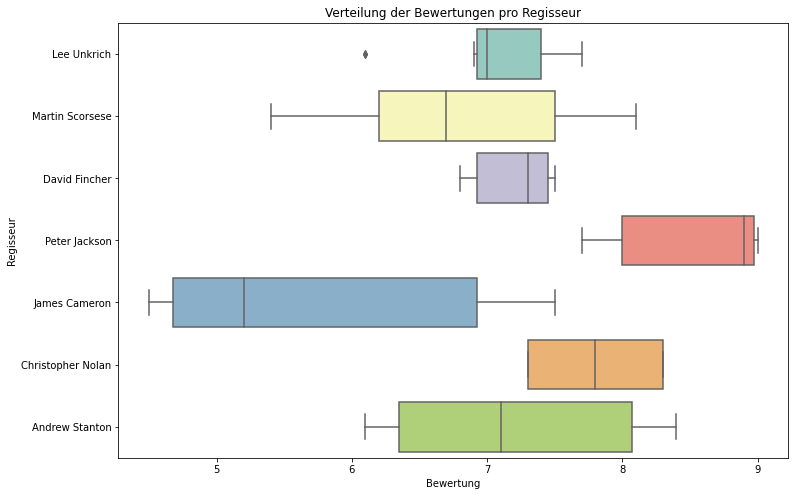

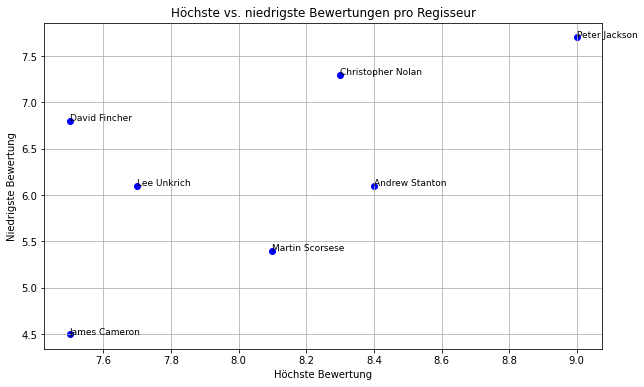

In [64]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(x='Rating', y='Director', data=df, palette='Set3')
plt.title('Verteilung der Bewertungen pro Regisseur')
plt.xlabel('Bewertung')
plt.ylabel('Regisseur')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(ratings_summary['Highest Rating'], ratings_summary['Lowest Rating'], c='blue', marker='o')
for i, txt in enumerate(ratings_summary['Director']):
    plt.annotate(txt, (ratings_summary['Highest Rating'].iloc[i], ratings_summary['Lowest Rating'].iloc[i]), fontsize=9)
plt.title('Höchste vs. niedrigste Bewertungen pro Regisseur')
plt.xlabel('Höchste Bewertung')
plt.ylabel('Niedrigste Bewertung')
plt.grid(True)
plt.show()

#### Boxplots

An den Boxplots ist deutlich zu erkennen, dass Regisseure wie Lee Unkrich, David Fincher und Christopher Nolan eine sehr konstante Bewertung aufweisen, da die Unterschiede zwischen den Bewertungen ihrer Filme gering sind. Peter Jackson zeichnet sich durch durchschnittlich sehr hohe Bewertungen aus. Im Gegensatz dazu zeigt James Cameron eine große Spannweite zwischen seinem bestbewerteten und seinem schlechtbewerteten Film, was auf eine variablere Rezeption seiner Werke hindeutet. 

#### Scatterplot

Peter Jackson befindet sich mit einem deutlichen Abstand in der rechten oberen Ecke des Scatterplots, wobei ihm Christopher Nolan am nächsten kommt. Dies zeigt, dass beide Regisseure durchweg hohe Bewertungen erhalten. James Cameron hingegen liegt im linken unteren Eck, was, wie bereits im Boxplot analysiert, darauf hinweist, dass die Bewertungen seiner Werke stark variieren.

## Vergleich

Unser Ziel ist es, die IMDb-Bewertungen bis zum Jahr 2020 mit den Rotten Tomatoes Bewertungen zu vergleichen sowie die IMDb-Bewertungen bis 2020 mit den IMDb-Bewertungen von 2020-2024 zu vergleichen.

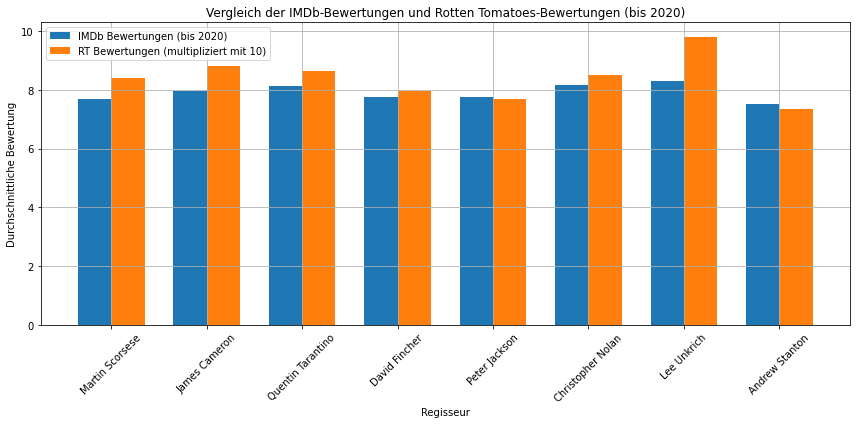

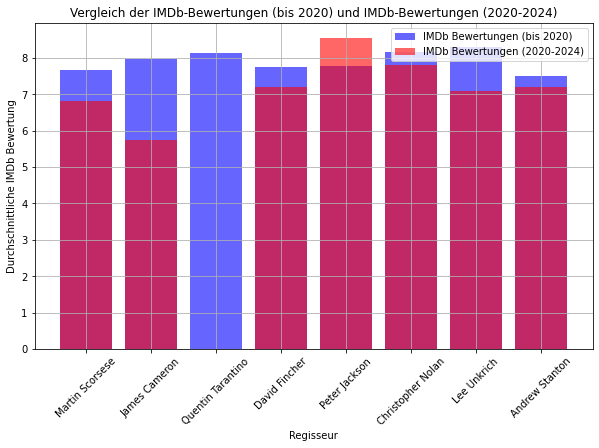

In [81]:
import numpy as np

bar_width = 0.35
index = np.arange(len(df_api['Director']))

plt.figure(figsize=(12, 6))

# Balken für IMDb-Ratings
plt.bar(index, df_api['Avg_IMDb_Rating'], bar_width, label='IMDb Bewertungen (bis 2020)')

# Balken für Rotten Tomatoes Ratings (multipliziert mit 10)
plt.bar(index + bar_width, df_api['Avg_RT_Rating'], bar_width, label='RT Bewertungen (multipliziert mit 10)')

plt.xlabel('Regisseur')
plt.ylabel('Durchschnittliche Bewertung')
plt.title('Vergleich der IMDb-Bewertungen und Rotten Tomatoes-Bewertungen (bis 2020)')
plt.xticks(index + bar_width / 2, df_api['Director'], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
plt.bar(df_api['Director'], df_api['Avg_IMDb_Rating'], color='blue', alpha=0.6, label='IMDb Bewertungen (bis 2020)')
plt.bar(ratings_summary['Director'], ratings_summary['Average Rating'], color='red', alpha=0.6, label='IMDb Bewertungen (2020-2024)')
plt.xlabel('Regisseur')
plt.ylabel('Durchschnittliche IMDb Bewertung')
plt.title('Vergleich der IMDb-Bewertungen (bis 2020) und IMDb-Bewertungen (2020-2024)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

#### Vergleich der IMDb und Roten Tomato Bewertung

In der ersten Grafik sehen wir ein Balkendiagramm, das die durchschnittlichen IMDb-Bewertungen und die Rotten Tomatoes-Bewertungen für die beliebtesten Regisseure bis zum Jahr 2020 vergleicht. Es ist zu erkennen, dass fast alle Regisseure auf Rotten Tomatoes eine höhere Bewertung aufweisen, mit Ausnahme von Peter Jackson und Andrew Stanton. Besonders auffällig ist der größere Unterschied bei Lee Unkrich, dessen Rotten Tomatoes-Bewertung deutlich höher ist als seine IMDb-Bewertung.

#### Vergleich der IMDb-Bewertung (bis 2020) und IMDb-Bewertung(2020-2024)

Im Allgemeinen scheinen die IMDb-Bewertungen für Filme, die nach 2020 veröffentlicht wurden, im Vergleich zu denen, die bis 2020 veröffentlicht wurden, niedriger zu sein. Die einzige Ausnahme bildet Peter Jackson, dessen Bewertungen nach 2020 sogar gestiegen sind. Quentin Tarantino hat seit 2020 offenbar keine neuen Filme mehr herausgebracht. Der größte Rückgang ist bei James Cameron zu beobachten, dessen IMDb-Bewertungen nach 2020 deutlich gesunken sind.

## Conclusion

Unsere Analyse zeigt, dass sich die Bewertungen von Filmen im Laufe der Zeit erheblich ändern können. Diese Veränderungen in den Bewertungen können auf eine Vielzahl von Faktoren zurückgeführt werden, darunter Veränderungen im Publikumsgeschmack, Schwankungen in der Qualität der produzierten Filme und verschiedene externe Einflüsse auf die Filmindustrie.

Es ist interessant zu beobachten, dass trotz der Unterschiede in den Bewertungsmethoden und Zielgruppen der verschiedenen Plattformen wie IMDb und Rotten Tomatoes die Abweichungen in den Bewertungen für die meisten Regisseure nicht extrem groß sind. Dies deutet darauf hin, dass es eine gewisse Konsistenz in der Wahrnehmung von Filmen gibt, unabhängig davon, welche Plattform zur Bewertung herangezogen wird.